In [1]:
import tensorflow as tf
import os
import pandas as pd
from tensorflow.keras.metrics import top_k_categorical_accuracy
from tensorflow.keras.applications.inception_v3 import preprocess_input
import cv2
import numpy as np
import matplotlib.pyplot as plt

53576 images found of 53576 total


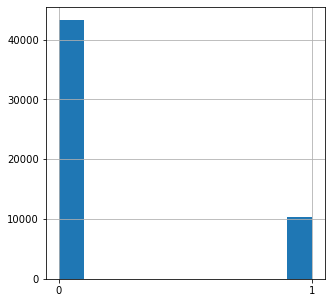

In [2]:
base_image_dir = os.path.join('/home/jupyter/tensorflow_datasets/downloads/')

negative = [0, 1]
positive = [2, 3, 4]

retina_df = pd.read_csv(os.path.join(base_image_dir, 'labels', 'testLabels15.csv'))
retina_df['path'] = retina_df['image'].map(lambda x: os.path.join(base_image_dir,'resized_test_15',
                                                         '{}.jpg'.format(x)))
retina_df['exists'] = retina_df['path'].map(os.path.exists)
print(retina_df['exists'].sum(), 'images found of', retina_df.shape[0], 'total')

retina_df.dropna(inplace = True)
retina_df = retina_df[retina_df['exists']].drop_duplicates()
retina_df['diagnosis'] = retina_df['level'].map(lambda x: str(0) if x in negative else str(1))
retina_df['diagnosis'].hist(figsize = (5, 5))
plt.show()

In [3]:
config = tf.compat.v1.ConfigProto(gpu_options =
                         tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8)
)
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)


In [4]:
batch_size = 32
IMG_SIZE = 512


test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=0, 
    horizontal_flip=False,
    vertical_flip=False, 
    # preprocess_input for no other preprocessing method; 
    # load_ben_color for graham pre-process;
    # auto_crop for auto cropping the image;
    preprocessing_function=preprocess_input,
    data_format="channels_last")

test_generator = test_datagen.flow_from_dataframe(retina_df, 
                                                  x_col='path', 
                                                  y_col='diagnosis',
                                                  target_size=(IMG_SIZE,IMG_SIZE),
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  class_mode='categorical')

Found 53576 validated image filenames belonging to 2 classes.


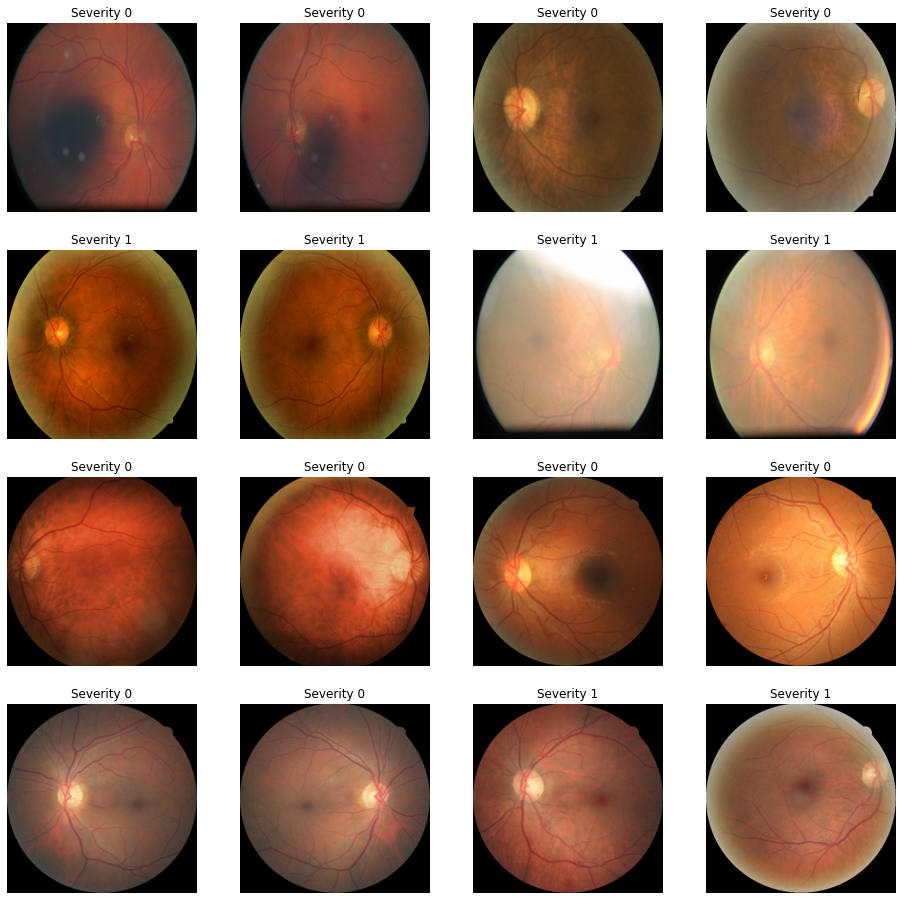

In [5]:
t_x, t_y = next(test_generator)
input_shape=t_x.shape[1:]
num_classes=t_y.shape[1]

fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(np.clip(c_x*127+127, 0, 255).astype(np.uint8))
    c_ax.set_title('Severity {}'.format(np.argmax(c_y, -1)))
    c_ax.axis('off')
#     print(c_x.dtype)
plt.show()


In [7]:
my_model = 'inception_resnet_v2_binary'


model_name = my_model+'_retina_model.h5'
model_weights = my_model+'_weights_best.hdf5'


new_model = tf.keras.models.load_model(model_name)

new_model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 14, 14, 1536)      54336736  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1536)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1536)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               196736    
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                

In [8]:
new_model.compile(optimizer = 'adam', 
                  loss = 'binary_crossentropy',
                  metrics = 'binary_accuracy')

new_model.load_weights(model_weights)

new_model.evaluate(test_generator,
                   verbose=1,
                   workers=8)

1675/1675 [==============================] - 1826s 1s/step - loss: 2.2733 - binary_accuracy: 0.8185


[2.273266315460205, 0.8185101747512817]